In [1]:
import glob
import tqdm
from nltk import word_tokenize
import spacy
import string
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import collections
import argparse
import os
import json
import time
import logging
import re
from collections import Counter
import string
punctuations = list(string.punctuation)
import warnings
warnings.simplefilter(action='ignore')#, category=FutureWarning)

In [2]:
def readFileNew_withTime(filename):
    '''
    This function is used to find out how much time a user would need to respond to a question
    input: transcript file name
    output: a list with timestamps within one transcript
    e.g. ['2019-03-31 12:32', '2019-03-31 12:32', ...]
    '''
    f = open(filename,"r")
    temp_list = []
    c = 0
    personName = ''
    botName = ''
    count = 0
    for i, line in enumerate(f):
        #print(line)
        c+=1
        if i==0:
            indBotNameSt = line.find(']')+1
            #first ":" appears in the timestamp
            indFirstCoBotName = line.find(':')
            indSecondCoBotName = indFirstCoBotName + line[indFirstCoBotName+1:].find(':') + 1
            botName = line[indBotNameSt:indSecondCoBotName].strip()
                
        elif not personName:            
            indPersonNameSt = line.find(']')+1
            indFirstCoPersonName = line.find(':')
            indSecondCoPersonName = indFirstCoPersonName + line[indFirstCoPersonName+1:].find(':') + 1
            tmpName = line[indPersonNameSt:indSecondCoPersonName].strip()
            if tmpName != botName:
                personName = tmpName
                    
        if line[1:3]=='20': #check if start with date
            if '{' not in line:
                indSentenceSt = line.find(']')+1
                temp_list.append(line[:indSentenceSt])
            else:
                indSentenceSt = line.find(']')+1
                if 'wording' in line:
                    temp_text = line[line.find(':wording')+8 : line.find(':qid')]
                    temp_list.append(line[:indSentenceSt])
                    #temp_list.append(botName+': single or multi'+str(count)+'ple choice Q')
                    count+=1
                else:
                    if botName not in line:
                        temp_list.append(line[:indSentenceSt])
            temp_list[-1] = temp_list[-1].rstrip('\n')
            
    return temp_list
def readFileNew(filename):
    '''
    input: transcript file name
    output: a list contains all the text
    e.g. ['Juji: Can you introduce yourself?', 'User: I love swimming', 'Juji: Thank you! Goodbye.']
    '''
    f = open(filename,"r")
    temp_list = []
    c = 0
    personName = ''
    botName = ''
    count = 0
    for i, line in enumerate(f):
        #print(line)
        c+=1
        if i==0:
            indBotNameSt = line.find(']')+1
            #first ":" appears in the timestamp
            indFirstCoBotName = line.find(':')
            indSecondCoBotName = indFirstCoBotName + line[indFirstCoBotName+1:].find(':') + 1
            botName = line[indBotNameSt:indSecondCoBotName].strip()
                
        elif not personName:            
            indPersonNameSt = line.find(']')+1
            indFirstCoPersonName = line.find(':')
            indSecondCoPersonName = indFirstCoPersonName + line[indFirstCoPersonName+1:].find(':') + 1
            tmpName = line[indPersonNameSt:indSecondCoPersonName].strip()
            if tmpName != botName:
                personName = tmpName
                    
        if line[1:3]=='20': #check if start with date
            if '{' not in line:
                indSentenceSt = line.find(']')+2
                temp_list.append(line[indSentenceSt:])
            else:
                if 'wording' in line:
                    subline = line[line.find(':wording')+8 : ]
                    temp_text = subline[:subline.index(',')]
                    if '<' in temp_text and '>' in temp_text and '*' in temp_text:
                        ind1, ind2 = temp_text.index('<'), temp_text.index('>')
                        temp_text = temp_text[:ind1]+temp_text[ind2+1:]
                        ind1, ind2 = temp_text.index('<'), temp_text.index('>')
                        temp_text = temp_text[:ind1]+temp_text[ind2+1:]
                        temp_text = temp_text.replace('*','')
                    temp_list.append(botName + ': ' + temp_text)
                    #temp_list.append(botName+': single or multi'+str(count)+'ple choice Q')
                    count+=1
                else:
                    if botName not in line:
                        temp_list.append(personName+': A')
            temp_list[-1] = temp_list[-1].rstrip('\n')
            
    return temp_list,count,botName
#remove transcrips that do not chat
def filterNonChattingTranscripts(transcripts_name):
    '''
    This function filters out empty transctipts
    input: a list of transcript files names
    output: 
        transcripts_afterFilter: a list with 'readFileNew' funtion's return value
        transcripts_withTime_afterFilter: a list with 'readFileNew_withTime' function's return value
        resbotName: bot's name
    '''
    all_transcripts = []
    filtered_transcripts = []
    
    transcripts_afterFilter = []
    count_choiceQuestions = []
    transcripts_withTime_afterFilter = []
    for i in range(len(transcripts_name)):
        t,c,botName = readFileNew(transcripts_name[i])
        t_time = readFileNew_withTime(transcripts_name[i])
        if botName != '':
            resbotName = botName
        all_transcripts.append(t)
        flag = True
        for j in range(len(t)):
            if not t[j].startswith(resbotName):
                flag = False
                break
                
        if flag:
            filtered_transcripts.append(t)
        else:
            transcripts_afterFilter.append(t)
            count_choiceQuestions.append(c)
            
            transcripts_withTime_afterFilter.append(t_time)
    return transcripts_afterFilter, transcripts_withTime_afterFilter,resbotName

#read from edn file to get question list
def getQuestions(filename):
    '''
    input: edn file name
    output: question list with punctuations removed
    '''
    QList = []
    with open(filename) as f:
        lines = f.readlines()
        flag = 0
        for line in lines:
            if flag:
                lBracket, rBracket = line.find('['), line.find(']')
                question = line[lBracket+2:rBracket-1]
                QList.append(question)
                flag = 0
                continue
            if ':wording' in line and ';;' not in line:
                flag = 1
    for i in range(len(QList)):
        if 'Are you working for' in QList[i]:
            QList[i] = 'Are you working for?'
    
    for j in range(len(QList)):
            QList[j]=QList[j].rstrip('\r')
            QList[j]=QList[j].replace("\r", " ")
            QList[j]=QList[j].strip()
            QList[j] = ' '.join([k.strip("".join(punctuations)) for k in word_tokenize(QList[j]) if k not in punctuations])
        
    return QList

#get question blocks
def groupQuestions(sentences,sentences_time,questions,botName):
    '''
    input: 
        sentences: the sentences list from "readFileNew" function's return value
        sentences_time: the timestamp list from "readFileNew_withTime" function's return value
        questions: question list
        botName
        
    output: 
        questionDict: a dict with key = question in question list, value = conversation block under the key question
        e.g {'q1': ['Juji: q1', 'User: answer to q1'], ...}
        
        questionDict_Time: a dict with key = question in question list, value = timestamp of the conversation block
        e.g {'q1': ['timestamp1', 'timestampe2'], ...}
    '''
    #sentences = readFile(filename)
    temp_list=[]
    last= 0
    lastq = 'starting'
    #nlp = spacy.load('en_pytt_bertbaseuncased_lg')
    Th = 0.7
    questionDict = collections.OrderedDict()
    questionDict_time = collections.OrderedDict()
    for i in range(len(sentences)):
        match = 0
        if sentences[i].startswith(botName+':'):#[:5] == 'Juji:':
            sen_rmPunct = ' '.join([i.strip("".join(punctuations)) for i in word_tokenize(sentences[i].strip()) if i not in punctuations])
            #print(sen_rmPunct)
            for q in questions:
                if q in sen_rmPunct:
                    match = 1   
                    
                    if lastq in questionDict:
                        questionDict[lastq] += sentences[last:i]
                        questionDict_time[lastq] += sentences_time[last:i]
                    else:
                        questionDict[lastq] = sentences[last:i]
                        questionDict_time[lastq] = sentences_time[last:i]
                    lastq = q
                    #temp_list.append(sentences[last:i])
                    if "Are you working for" in q:
                        lastq = "Are you working for"
                    last = i

    #temp_list.append(sentences[last:])
    if lastq in questionDict:
        questionDict[lastq] += sentences[last:]
        questionDict_time[lastq] += sentences_time[last:]
    else:
        questionDict[lastq] = sentences[last:]
        questionDict_time[lastq] = sentences_time[last:]
    #print(questionDict)
    return questionDict, questionDict_time#list(questionDict.values())
def groupQuestions_csv(filename):
    '''
    input: 
        csv file name
        
    output: 
        qBlocks: a dict with key = question in question list, value = conversation block under the key question
        e.g {'q1': ['Juji: q1', 'User: answer to q1'], ...}
        qList: question list
        
    '''
    df = pd.read_csv(filename,encoding='iso8859-1')
    botName = 'Juji'
    qBlocks = []
    qList = df.columns.tolist()[5:]
    finalQuestion = 'Any final thoughts?'
    qList_normal = qList[:qList.index(finalQuestion)+1]
    qList_addtional = qList[qList.index(finalQuestion)+1:]
    
    for i in range(len(df)):
        block = collections.OrderedDict()
        line = df.iloc[i]
        if pd.isnull(line[qList_normal[0]]):
            continue
        for q in qList_normal:
            if not pd.isnull(line[q]):
                block[q] = [botName+':'+q, line['Name']+':'+str(line[q])]
            #else:
            #    block[q] = [botName+':'+q]
            #    break
        qBlocks.append(block)
        
    '''    
    #remove punctuation in question list
    for j in range(len(qList_normal)):
            qList_normal[j]=qList_normal[j].rstrip('\r')
            qList_normal[j]=qList_normal[j].replace("\r", " ")
            qList_normal[j]=qList_normal[j].strip()
            qList_normal[j] = ' '.join([k.strip("".join(punctuations)) for k in word_tokenize(qList_normal[j]) if k not in punctuations])
    for j in range(len(qList_addtional)):
            qList_addtional[j]=qList_addtional[j].rstrip('\r')
            qList_addtional[j]=qList_addtional[j].replace("\r", " ")
            qList_addtional[j]=qList_addtional[j].strip()
            qList_addtional[j] = ' '.join([k.strip("".join(punctuations)) for k in word_tokenize(qList_addtional[j]) if k not in punctuations])
    '''
    return qBlocks,qList_normal

In [17]:
def containHateWord(transcripts_blocks,botName):
    '''
    input:
    transcripts_blocks: a list of dicts with key = question in question list, value = conversation block under the key question
        e.g [{'q1': ['Juji: q1', 'User1: answer to q1'], ...}, {'q1': ['Juji: q1', 'User2: answer to q1'], ...} ... ]
        botName
    output: a dict with key=question, value = avg swear words frequency in the question related conversation blocks
    '''
    dic = collections.defaultdict(lambda: 0)
    hateWord = collections.defaultdict(int)
    with open('resource/Offensivewords.txt') as f: # ref: https://www.cs.cmu.edu/~biglou/resources/
        offensiveWordList = f.readlines()
    offensiveWordList = [x.rstrip('\n') for x in offensiveWordList]
    for block in transcripts_blocks:
        for question in block:
            botText = ''
            #get full text from bot
            for line in block[question]:
                if line.startswith(botName):
                    botText += line[line.find(':')+1:]
            tokenized = word_tokenize(botText)
            for word in offensiveWordList:
                if word in tokenized:
                    dic[question] += 1  
                    print(word)
                    print(botText)
            #txt_tokens = tokenize_text_LIWC(botText)
            # now flatmap over all the categories in all of the tokens using a generator:
            #count_cat = Counter(category for token in txt_tokens for category in parser_LIWC(token))
            #dic[question].append(count_cat['swear'])#percept
    #for question in dic:
    #    hateWord[question] = np.mean(dic[question])
    return dic

In [10]:
import matplotlib.pyplot as plt
def visRes(qList, dic):
    rate = [dic[q] for q in qList if q in dic]
    question = [q for q in qList if q in dic]
    plt.plot(question,rate)
    plt.xticks(rotation=90)
    plt.show()

In [11]:
def main(readCsv=False,csvFileName=None, transcriptFilesPath=None,qListPath=None):
    if readCsv:
        transcripts_blocks,q = groupQuestions_csv(csvFileName)
        botName = 'Juji'
    else:
        transcripts_blocks = []
        transcripts_name = glob.glob(transcriptFilesPath)
        transcripts_afterFilter, transcripts_withTime_afterFilter,botName = filterNonChattingTranscripts(transcripts_name)
        q = getQuestions(qListPath)
        for i in tqdm.tqdm_notebook(range(len(transcripts_afterFilter))):
            trans_block, trans_block_time = groupQuestions(transcripts_afterFilter[i],transcripts_withTime_afterFilter[i],q,botName)
            transcripts_blocks.append(trans_block)
    offensiveLevel = containHateWord(transcripts_blocks,botName)
    visRes(q, offensiveLevel)
    return offensiveLevel

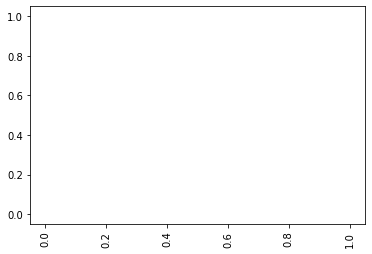

In [12]:
#if input is a csv file
offensive = main(True,'test-set/gamer.csv')

In [13]:
offensive

defaultdict(<function __main__.containHateWord.<locals>.<lambda>>, {})


hell
 You might have said it already, if you did, just text skip. Otherwise, where did you hear about us? Although I might be biased, I'd say hell is a reliable source of information. This is my last question - your answer may help me improve.
kill
 In my spare time, I love to chat with my sisters and brothers. What do you enjoy doing in your spare time? I guess we have that in common. I can be an AI companion, chatting with humans to kill time :-) Okay. Could we go back to our question?   What do you enjoy doing in your spare time? I'm really happy for you that you spend time with your friends, who would not want to do so? Oh, I almost forget… I should have said earlier I am still an AI baby far from perfect, so I might hiccup in our chat.


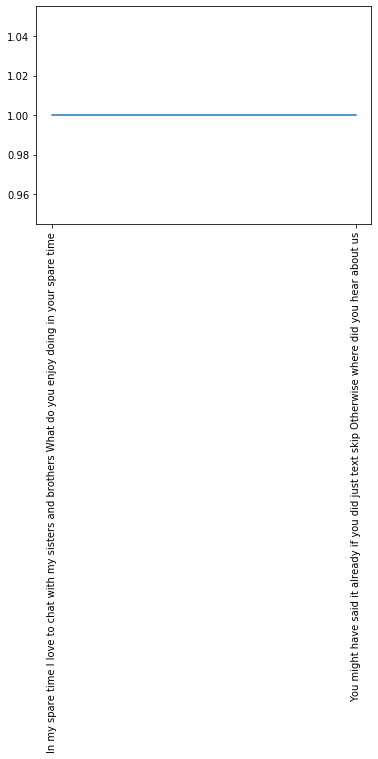

In [25]:
#if input is transcripts
offensiveLevel = main(False,None,'test-set/welcome-transcripts/*.txt','test-set/welcome.edn')

In [26]:
offensiveLevel

defaultdict(<function __main__.containHateWord.<locals>.<lambda>>,
            {'In my spare time I love to chat with my sisters and brothers What do you enjoy doing in your spare time': 1,
             'You might have said it already if you did just text skip Otherwise where did you hear about us': 1})